In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit, minimize

# Non-linear treatment effects in Pricing & Promotions

In [79]:
def michaelis_menten(x, alpha, lam):
    return alpha * x / (lam + x)

$$ v = \frac{V_{\max} [S]}{K_m + [S]} $$


In [80]:
def curve_example(alpha, lam):

    linear_x = np.linspace(0, 1000, 100)

    nonlinear_y = michaelis_menten(linear_x, alpha, lam)
    
    return linear_x, nonlinear_y

In [81]:
linear_x_1, nonlinear_y_1 = curve_example(10000, 1000)
linear_x_2, nonlinear_y_2 = curve_example(10000, 500)
linear_x_3, nonlinear_y_3 = curve_example(10000, 250)
linear_x_4, nonlinear_y_4 = curve_example(5000, 1000)
linear_x_5, nonlinear_y_5 = curve_example(5000, 500)
linear_x_6, nonlinear_y_6 = curve_example(5000, 250)
linear_x_7, nonlinear_y_7 = curve_example(2500, 1000)
linear_x_8, nonlinear_y_8 = curve_example(2500, 500)
linear_x_9, nonlinear_y_9 = curve_example(2500, 250)

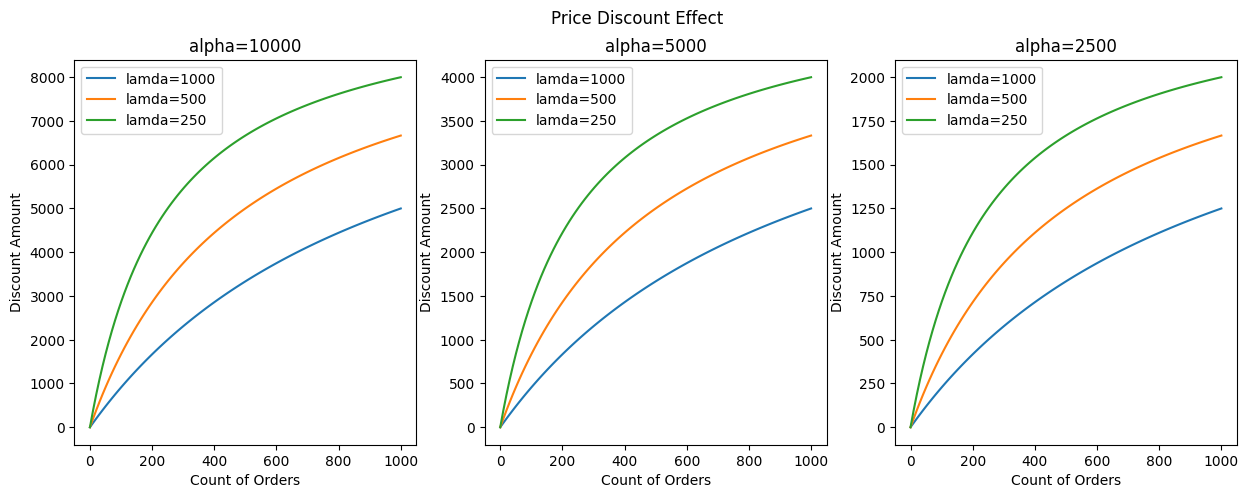

In [82]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plots on each subplot
sns.lineplot(x=linear_x_1, y=nonlinear_y_1, ax=axes[0], label='lamda=1000')
sns.lineplot(x=linear_x_2, y=nonlinear_y_2, ax=axes[0], label='lamda=500')
sns.lineplot(x=linear_x_3, y=nonlinear_y_3, ax=axes[0], label='lamda=250')
axes[0].set_title('alpha=10000')
axes[0].set_xlabel('Count of Orders')
axes[0].set_ylabel('Discount Amount')

sns.lineplot(x=linear_x_4, y=nonlinear_y_4, ax=axes[1], label='lamda=1000')
sns.lineplot(x=linear_x_5, y=nonlinear_y_5, ax=axes[1], label='lamda=500')
sns.lineplot(x=linear_x_6, y=nonlinear_y_6, ax=axes[1], label='lamda=250')
axes[1].set_title('alpha=5000')
axes[1].set_xlabel('Count of Orders')
axes[1].set_ylabel('Discount Amount')

sns.lineplot(x=linear_x_7, y=nonlinear_y_7, ax=axes[2], label='lamda=1000')
sns.lineplot(x=linear_x_8, y=nonlinear_y_8, ax=axes[2], label='lamda=500')
sns.lineplot(x=linear_x_9, y=nonlinear_y_9, ax=axes[2], label='lamda=250')
axes[2].set_title('alpha=2500')
axes[2].set_xlabel('Count of Orders')
axes[2].set_ylabel('Discount Amount')

# Add labels to the entire figure
fig.suptitle('Price Discount Effect')

# Show plots
plt.show()

# Data generating process

|Variable|Description|
|-|-|
|x0|Demand|
|x1|Marketing spend|
|x2|Competitor discount amount|
|x3|Competitor marketing spend|
|T|Discount amount|
|y|Count of orders|

In [83]:
def data_generator(n, tau_weight, alpha, lam):

    # Set number of features
    p=4

    # Create features
    X = np.random.uniform(size=n * p).reshape((n, -1))

    # Nuisance parameters
    b = (
        np.sin(np.pi * X[:, 0])
        + 2 * (X[:, 1] - 0.5) ** 2
        + X[:, 2] * X[:, 3]
    )

    # Create treatment and treatment effect
    T = np.linspace(200, 10000, n)
    T_mm = michaelis_menten(T, alpha, lam) * tau_weight
    tau = T_mm / T

    # Calculate outcome
    y = b + T * tau + np.random.normal(size=n) * 0.5
    
    y_train = y
    X_train = np.hstack((X, T.reshape(-1, 1)))
    
    return y_train, X_train, T_mm, tau

In [84]:
np.random.seed(1234)

n=100000

y_train_1, X_train_1, T_mm_1, tau_1 = data_generator(n, 1.00, 2, 5000)
y_train_2, X_train_2, T_mm_2, tau_2 = data_generator(n, 0.25, 2, 5000)
y_train_3, X_train_3, T_mm_3, tau_3 = data_generator(n, 2.00, 2, 5000)

# S-Learner

In [85]:
def train_slearner(X_train, y_train):
    
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)

    yhat_train = model.predict(X_train)

    mse_train = mean_squared_error(y_train, yhat_train)
    r2_train = r2_score(y_train, yhat_train)

    print(f'MSE on train set is {round(mse_train)}')
    print(f'R2 on train set is {round(r2_train, 2)}')
    
    return model, yhat_train

In [86]:
np.random.seed(1234)

model_1, yhat_train_1 = train_slearner(X_train_1, y_train_1)
model_2, yhat_train_2 = train_slearner(X_train_2, y_train_2)
model_3, yhat_train_3 = train_slearner(X_train_3, y_train_3)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 5
[LightGBM] [Info] Start training from score 1.972913
MSE on train set is 0
R2 on train set is 0.54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 5
[LightGBM] [Info] Start training from score 1.282954
MSE on train set is 0
R2 on train set is 0.43
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001327 seconds.
You can set `force_row_wise=true` to remove the overhead

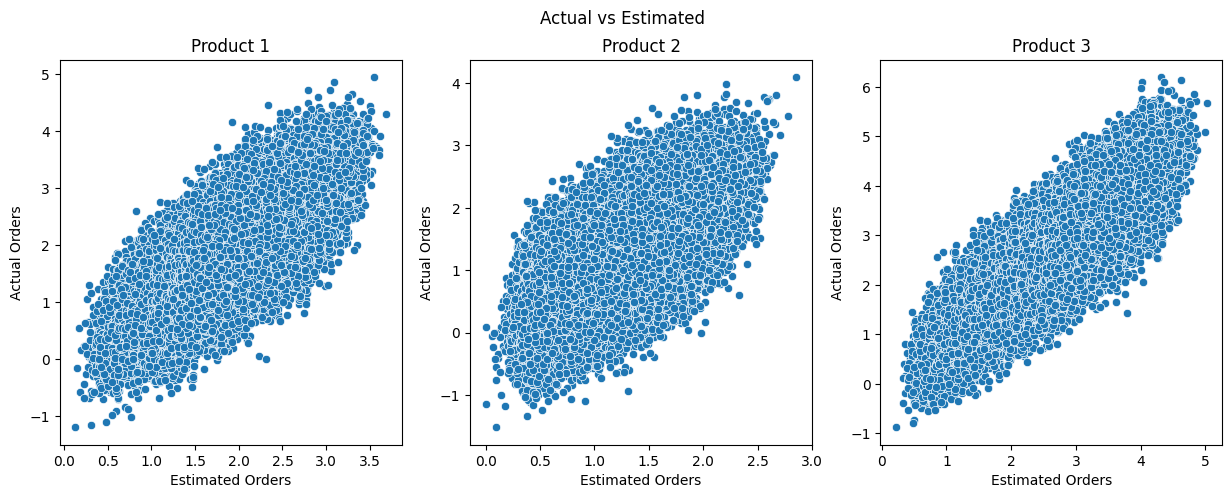

In [87]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plots on each subplot
sns.scatterplot(x=yhat_train_1, y=y_train_1, ax=axes[0])
axes[0].set_title('Product 1')
axes[0].set_xlabel('Estimated Orders')
axes[0].set_ylabel('Actual Orders')

sns.scatterplot(x=yhat_train_2, y=y_train_2, ax=axes[1])
axes[1].set_title('Product 2')
axes[1].set_xlabel('Estimated Orders')
axes[1].set_ylabel('Actual Orders')

sns.scatterplot(x=yhat_train_3, y=y_train_3, ax=axes[2])
axes[2].set_title('Product 3')
axes[2].set_xlabel('Estimated Orders')
axes[2].set_ylabel('Actual Orders')

# Add labels to the entire figure
fig.suptitle('Actual vs Estimated')

# Show plots
plt.show()

# Extracting treatment effect

In [88]:
def extract_treated_effect(n, X_train, model):
    
    # Set features to mean value
    X_mean_mapping = {'X1': [X_train[:, 0].mean()] * n,
                      'X2': [X_train[:, 1].mean()] * n,
                      'X3': [X_train[:, 2].mean()] * n,
                      'X4': [X_train[:, 3].mean()] * n}

    # Create DataFrame
    df_scoring = pd.DataFrame(X_mean_mapping)

    # Add full range of treatment values
    df_scoring['T'] = X_train[:, 4].reshape(-1, 1)

    # Calculate outcome prediction for treated
    treated = model.predict(df_scoring)
    
    return treated, df_scoring

In [89]:
treated_1, df_scoring_1 = extract_treated_effect(n, X_train_1, model_1)
treated_2, df_scoring_2 = extract_treated_effect(n, X_train_2, model_2)
treated_3, df_scoring_3 = extract_treated_effect(n, X_train_3, model_3)

In [90]:
def extract_untreated_effect(n, X_train, model):
    
    # Set features to mean value
    X_mean_mapping = {'X1': [X_train[:, 0].mean()] * n,
                      'X2': [X_train[:, 1].mean()] * n,
                      'X3': [X_train[:, 2].mean()] * n,
                      'X4': [X_train[:, 3].mean()] * n,
                      'T': [0] * n}

    # Create DataFrame
    df_scoring = pd.DataFrame(X_mean_mapping)

    # Add full range of treatment values
    df_scoring

    # Calculate outcome prediction for treated
    untreated = model.predict(df_scoring)
    
    return untreated

In [91]:
untreated_1 = extract_untreated_effect(n, X_train_1, model_1)
untreated_2 = extract_untreated_effect(n, X_train_2, model_2)
untreated_3 = extract_untreated_effect(n, X_train_3, model_3)

In [92]:
# Calculate treatment effect
treatment_effect_1 = treated_1 - untreated_1
treatment_effect_2 = treated_2 - untreated_2
treatment_effect_3 = treated_3 - untreated_3

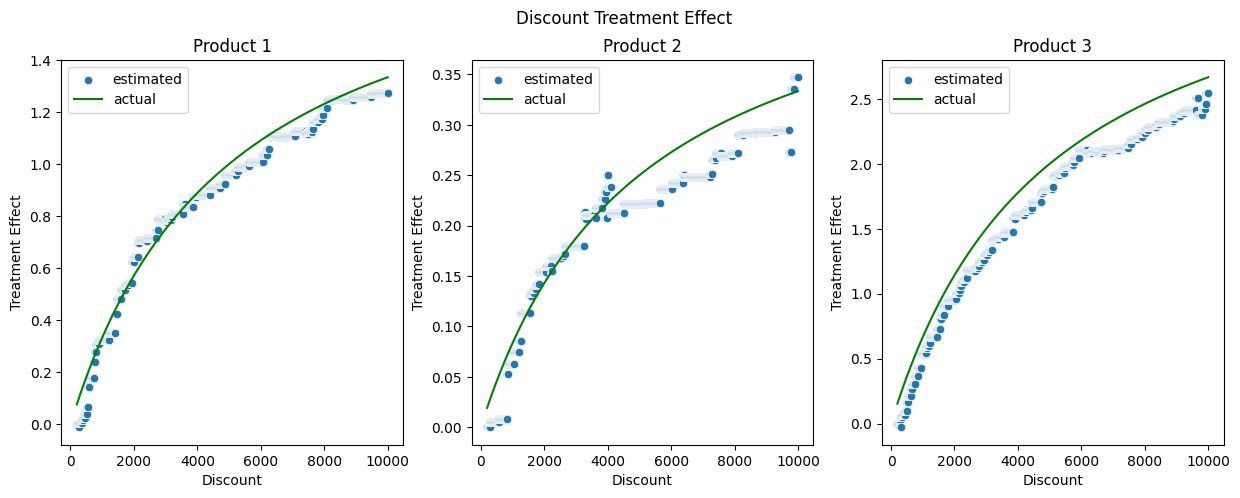

In [93]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plots on each subplot
sns.scatterplot(x=df_scoring_1['T'], y=treatment_effect_1, ax=axes[0], label='estimated')
sns.lineplot(x=df_scoring_1['T'], y=T_mm_1, ax=axes[0], color='green', label='actual')
axes[0].set_title('Product 1')
axes[0].set_xlabel('Discount')
axes[0].set_ylabel('Treatment Effect')

sns.scatterplot(x=df_scoring_2['T'], y=treatment_effect_2, ax=axes[1], label='estimated')
sns.lineplot(x=df_scoring_2['T'], y=T_mm_2, ax=axes[1], color='green', label='actual')
axes[1].set_title('Product 2')
axes[1].set_xlabel('Discount')
axes[1].set_ylabel('Treatment Effect')

sns.scatterplot(x=df_scoring_3['T'], y=treatment_effect_3, ax=axes[2], label='estimated')
sns.lineplot(x=df_scoring_3['T'], y=T_mm_3, ax=axes[2], color='green', label='actual')
axes[2].set_title('Product 3')
axes[2].set_xlabel('Discount')
axes[2].set_ylabel('Treatment Effect')

# Add labels to the entire figure
fig.suptitle('Discount Treatment Effect')

# Show plots
plt.show()

# Curve fit

In [94]:
def response_curves(treatment_effect, df_scoring):
    
    maxfev = 100000
    lam_initial_estimate = 0.001
    alpha_initial_estimate = max(treatment_effect)
    initial_guess = [alpha_initial_estimate, lam_initial_estimate]

    popt, pcov = curve_fit(michaelis_menten, df_scoring['T'], treatment_effect, p0=initial_guess, maxfev=maxfev)
    
    return popt, pcov

In [95]:
popt_1, pcov_1 = response_curves(treatment_effect_1, df_scoring_1)
popt_2, pcov_2 = response_curves(treatment_effect_2, df_scoring_2)
popt_3, pcov_3 = response_curves(treatment_effect_3, df_scoring_3)

In [96]:
treatment_effect_curve_1 = michaelis_menten(df_scoring_1['T'], popt_1[0], popt_1[1])
treatment_effect_curve_2 = michaelis_menten(df_scoring_2['T'], popt_2[0], popt_2[1])
treatment_effect_curve_3 = michaelis_menten(df_scoring_3['T'], popt_3[0], popt_3[1])

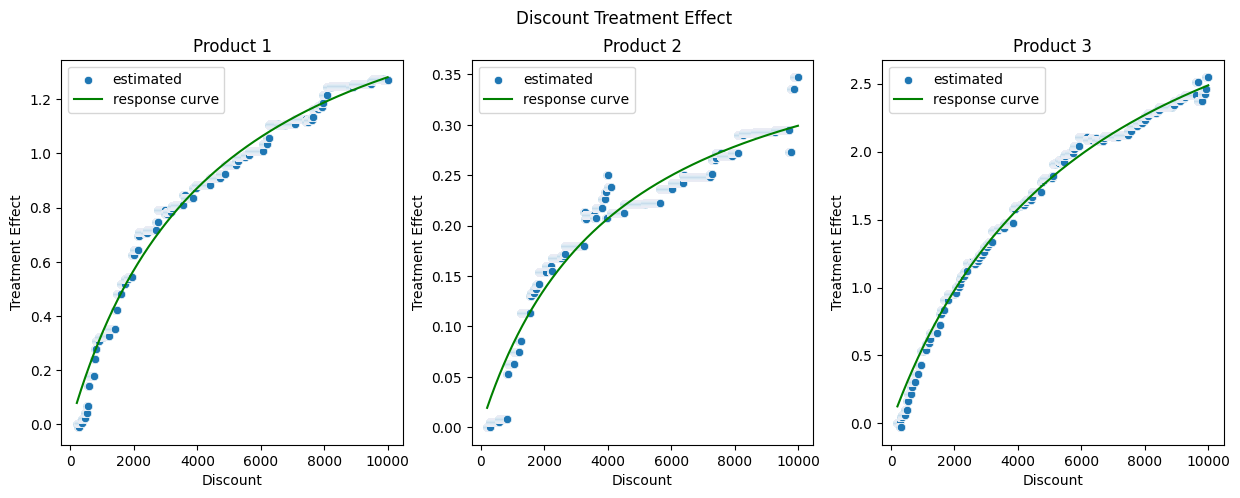

In [97]:
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot scatter plots on each subplot
sns.scatterplot(x=df_scoring_1['T'], y=treatment_effect_1, ax=axes[0], label='estimated')
sns.lineplot(x=df_scoring_1['T'], y=treatment_effect_curve_1, ax=axes[0], color='green', label='response curve')
axes[0].set_title('Product 1')
axes[0].set_xlabel('Discount')
axes[0].set_ylabel('Treatment Effect')

sns.scatterplot(x=df_scoring_2['T'], y=treatment_effect_2, ax=axes[1], label='estimated')
sns.lineplot(x=df_scoring_2['T'], y=treatment_effect_curve_2, ax=axes[1], color='green', label='response curve')
axes[1].set_title('Product 2')
axes[1].set_xlabel('Discount')
axes[1].set_ylabel('Treatment Effect')

sns.scatterplot(x=df_scoring_3['T'], y=treatment_effect_3, ax=axes[2], label='estimated')
sns.lineplot(x=df_scoring_3['T'], y=treatment_effect_curve_3, ax=axes[2], color='green', label='response curve')
axes[2].set_title('Product 3')
axes[2].set_xlabel('Discount')
axes[2].set_ylabel('Treatment Effect')

# Add labels to the entire figure
fig.suptitle('Discount Treatment Effect')

# Show plots
plt.show()

# Optimisation

In [98]:
# List of products
products = ["product_1", "product_2", "product_3"]

# Set total budget to be the sum of the mean of each product reduced by 20%
total_budget = (df_scoring_1['T'].mean() + df_scoring_2['T'].mean() + df_scoring_3['T'].mean()) * 0.80

# Dictionary with min and max bounds for each product - set as +/-20% of max/min discount
budget_ranges = {"product_1": [df_scoring_1['T'].min() * 0.80, df_scoring_1['T'].max() * 1.2], 
                 "product_2": [df_scoring_2['T'].min() * 0.80, df_scoring_2['T'].max() * 1.2], 
                 "product_3": [df_scoring_3['T'].min() * 0.80, df_scoring_3['T'].max() * 1.2]}

# Dictionary with response curve parameters
parameters = {"product_1": [popt_1[0], popt_1[1]], 
              "product_2": [popt_2[0], popt_2[1]], 
              "product_3": [popt_3[0], popt_3[1]]}

In [102]:
def objective_function(x, products, parameters):

    sum_orders = 0.0

    # Unpack parameters for each product and calculate expected orders
    for product, budget in zip(products, x, strict=False):
        L, k = parameters[product]
        sum_orders += michaelis_menten(budget, L, k)

    return -1 * sum_orders

In [103]:
# Set initial guess by equally sharing out the total budget
initial_guess = [total_budget // len(products)] * len(products)

# Set the lower and upper bounds for each product
bounds = [budget_ranges[product] for product in products]

# Set the equality constraint - constraining the total budget
constraints = {"type": "eq", "fun": lambda x: np.sum(x) - total_budget}

# Run optimisation
result = minimize(
    lambda x: objective_function(x, products, parameters),
    initial_guess,
    method="SLSQP",
    bounds=bounds,
    constraints=constraints,
    options={'disp': True, 'maxiter': 1000, 'ftol': 1e-9},
)

# Extract results
optimal_treatment = {product: budget for product, budget in zip(products, result.x, strict=False)}
print(f'Optimal promo budget allocations: {optimal_treatment}')
print(f'Optimal orders: {round(result.fun * -1, 2)}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3.167157614000325
            Iterations: 13
            Function evaluations: 52
            Gradient evaluations: 13
Optimal promo budget allocations: {'product_1': 3617.435830746839, 'product_2': 160.0, 'product_3': 8462.56416925316}
Optimal orders: 3.17
